In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

In [2]:
from nca.utils import conv_same

In [3]:
def rescale_pil(pil, scale=1):
    W, H = pil.size
    new_W = int(W * scale)
    new_H = int(H * scale)
    return pil.resize((new_W, new_H), Image.NEAREST)

In [4]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [5]:
def gif_from_pils(pils, fps):
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [6]:
def make_gif(nca_out, fps=10, size=(500, 500)):
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize(size, Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [7]:
# [[[i/xpix, j/ypix] for j in range(xpix)] for i in range(ypix)]

In [8]:
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise

def pnoise(size, oct=10, seed=1):
    noise = PerlinNoise(octaves=oct, seed=seed)
    xpix, ypix = size, size

    pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
    return np.array(pic)

pic = pnoise(10, 3)
# plt.imshow(pic, cmap='gray')

In [9]:
def growth(x, mu=0, s=2):
    return torch.exp(-((x - mu)/s) ** 2) * 2 - 1

In [462]:
def get_circular_kernel(s):
    xx = np.linspace(-1, 1, s)
    yy = np.linspace(-1, 1, s)
    d = 1 - np.linalg.norm(np.stack(np.meshgrid(xx, yy), axis=-1), axis=-1)
    d = np.clip(d, 0, 1)
    return d

In [640]:
def get_kernel(ks, p, s):
    k = pnoise(ks, p, seed=s) 
    k = abs(k)
    k = np.concatenate([k, k[:,::-1]], axis=1)
    k = np.concatenate([k, k[::-1]])
    k = k * get_circular_kernel(k.shape[0])
    k = k / k.sum()
    return k

In [641]:
kernels = [[get_kernel(ks=30, p=p, s=s) for p in np.linspace(0.1, 8, 10)] for s in range(4)]

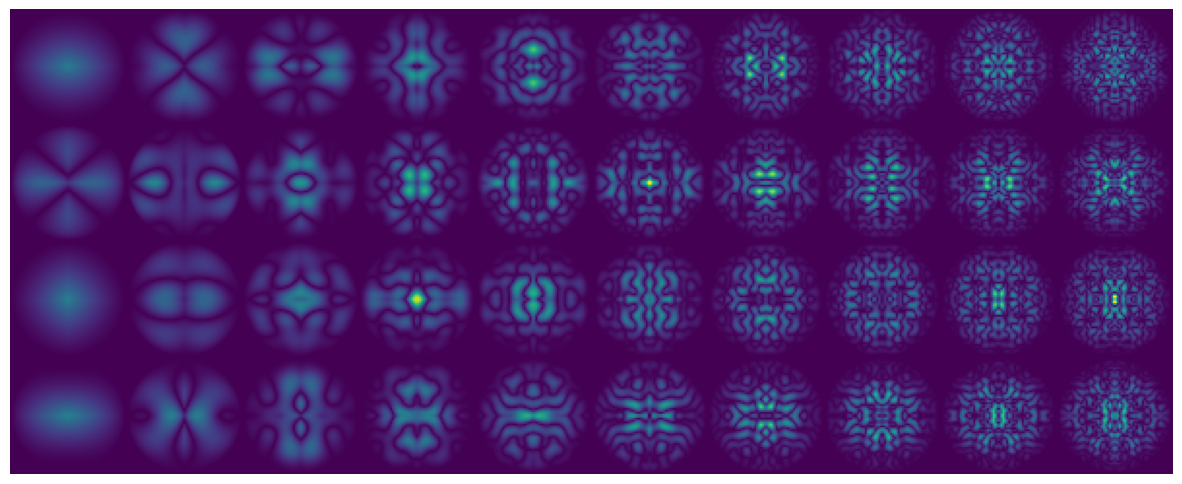

In [642]:
plt.subplots(figsize=(15, 15))

plt.axis("off")
plt.ylabel("seed")
plt.xlabel("octave")
plt.imshow(np.concatenate([np.concatenate(ks, axis=1) for ks in kernels], axis=0))
plt.show()

In [633]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.k = get_kernel(ks=20, p=1.5, s=1)
        self.kernel = conv_same(1, 1, ks=self.k.shape[0])
        self.kernel.weight.data = torch.tensor(
            self.k, dtype=torch.float32
        ).unsqueeze(0).unsqueeze(0)

        self.mu =  0.125
        self.s = 0.03

    def forward(self, x, steps):
        seq = [x]
        convs = []
        l = 1/4

        for i in range(steps):
            perc = self.kernel(x)
            convs.append(perc)
            x = torch.clip(x + l * growth(perc, self.mu, s=self.s), 0, 1)
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        convs = torch.stack(convs, axis=1)
        return seq, convs

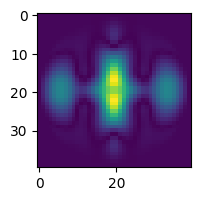

In [634]:
nca = SimpleNCA()

bs = 8
steps = 50
inp = torch.zeros(bs, 1, 120, 120)
for bi in range(bs):
    val = 1.1 - (0.1 + (bi / (bs - 1)) * 0.9)
    rand = (torch.rand(60, 60) < val) / 2
    rand *= get_circular_kernel(60)
    inp[bi, 0, 30:90, 30:90] = rand

out, convs = nca(inp, steps=steps)

plt.subplots(figsize=(2, 2))
plt.imshow(nca.kernel.weight[0, 0].detach().cpu())

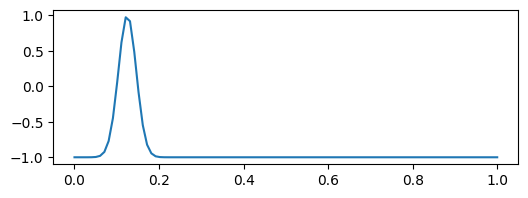

In [635]:
xx = torch.linspace(0, 1, 100)
yy = growth(xx, nca.mu, nca.s)

plt.subplots(figsize=(6, 2))
plt.plot(xx, yy)

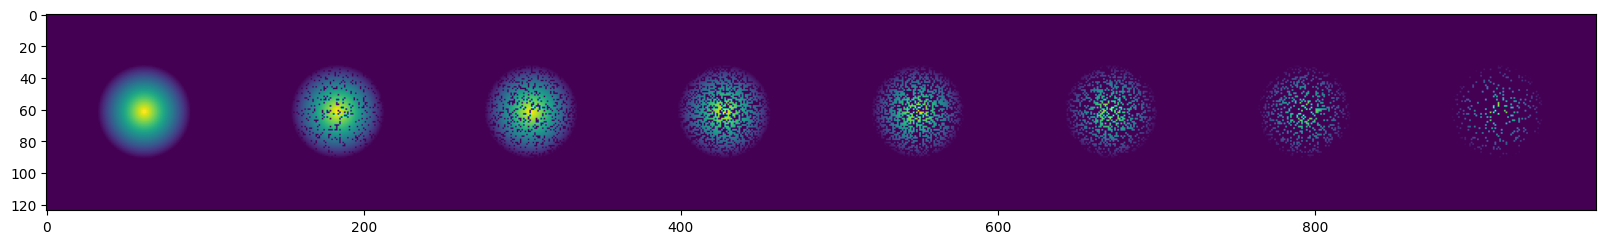

In [636]:
plt.subplots(figsize=(20, 20))
plt.imshow(torchvision.utils.make_grid(inp, nrow=8)[0])

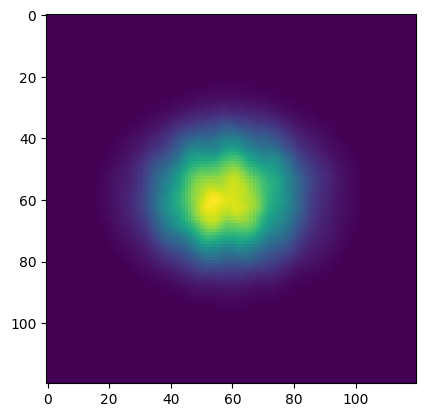

In [637]:
activ = nca.kernel(inp)[4, 0].detach().cpu()
plt.imshow(activ)

In [638]:
pils = []
for s in tqdm(range(steps)):
    o = out[:, s, 0].detach().cpu()
    o = plt.cm.viridis(o)
    o = torch.tensor(o).permute(0, 3, 1, 2)
    o = torchvision.utils.make_grid(o, nrow=4)
    o = (o.permute(1, 2, 0)[:,:,:3] * 255).numpy().astype(np.uint8)
    pil = Image.fromarray(o)
    pil = rescale_pil(pil, 2)
    pils.append(pil)
    
gif = gif_from_pils(pils, fps=10)

  0%|          | 0/50 [00:00<?, ?it/s]


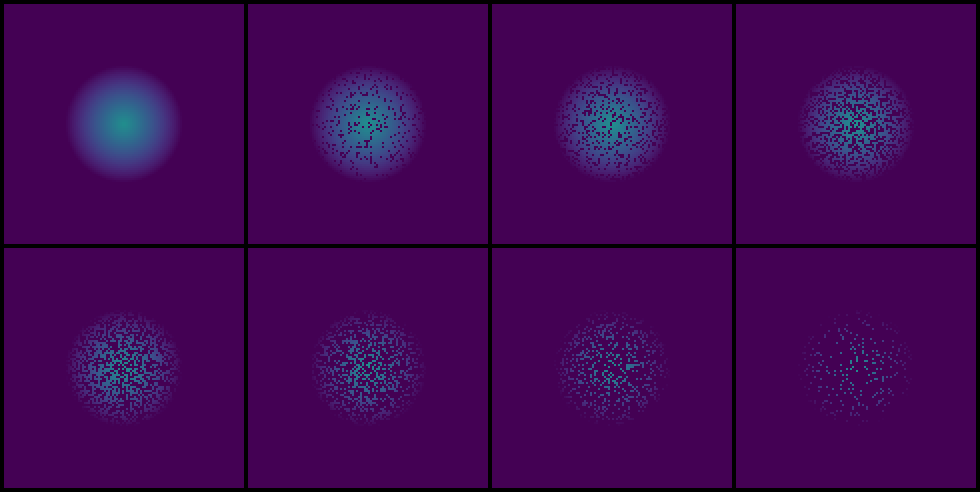

In [639]:
gif